# Project 4 - Group 6

## Clean up for the maindata set : data/tmdb_5000_movies.csv' will be comprised of : 
   - x
   - x
   - x
   - x





In [75]:
# Import required dependencies 
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Extract, Transform, & Load (ETL) the CSV files 

Reading in the first CSV file from the movies dataset and conducting the ETL process. 

In [76]:
# Read the movie CSV file
df1 = pd.read_csv('data/tmdb_5000_movies.csv')

# Print the first few rows of each DataFrame
print("DataFrame 1:")
print(df1.head())


DataFrame 1:
      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"i

Dropping non-relevant columns and other columns that are being parsed out into separate new dataframes for the ETL process. 

In [77]:
# Drop the specified columns
df1 = df1.drop(columns=['homepage', 'original_title', 'overview', 'spoken_languages'])

# Drop the fields that have been parsed out to new DataFrames (genres, keywords, production_companies)
movie_metadata_df = df1.drop(columns=['genres', 'keywords', 'production_companies'])

In [78]:
# Create a mapping DataFrame for languages movie were created in for acronymn and full name 
language_mapping_df = pd.DataFrame({
    'language': ['en', 'de', 'es', 'zh', 'ja', 'fr', 'da', 'it', 'sv', 'hi',
                 'ru', 'pt', 'ko', 'af', 'ro', 'nl', 'ar', 'he', 'th', 'cn',
                 'tr', 'cs', 'fa', 'no', 'ps', 'vi', 'el', 'hu', 'nb', 'xx',
                 'id', 'pl', 'is', 'te', 'ta', 'ky', 'sl'],
    'full_original_name': ['English', 'German', 'Spanish', 'Chinese', 'Japanese', 'French',
                           'Danish', 'Italian', 'Swedish', 'Hindi', 'Russian', 'Portuguese',
                           'Korean', 'Afrikaans', 'Romanian', 'Dutch', 'Arabic', 'Hebrew',
                           'Thai', 'Chinese', 'Turkish', 'Czech', 'Persian', 'Norwegian',
                           'Pashto', 'Vietnamese', 'Greek', 'Hungarian', 'Norwegian Bokmål',
                           'Unknown', 'Indonesian', 'Polish', 'Icelandic', 'Telugu', 
                           'Tamil', 'Kyrgyz', 'Slovenian']
})

# Merge the mapping DataFrame with your existing DataFrame
movie_metadata_df = movie_metadata_df.merge(
    language_mapping_df,
    left_on='original_language',  # Column with the language acronym
    right_on='language',          # Column in the mapping DataFrame
    how='left'
)

# Display the updated DataFrame, including the new column
print(movie_metadata_df[['original_language', 'full_original_name']])


     original_language full_original_name
0                   en            English
1                   en            English
2                   en            English
3                   en            English
4                   en            English
...                ...                ...
4798                es            Spanish
4799                en            English
4800                en            English
4801                en            English
4802                en            English

[4803 rows x 2 columns]


Iterating through the production country column to create new columns for the country acronym and full name. 

In [79]:
# Function to parse the first movie production country

def parse_first_country(row):
    try:
        # Load the JSON string from the 'production_countries' column
        countries = json.loads(row['production_countries'])
        if countries:
            # Extract the first country's iso_3166_1 and name
            return countries[0]['iso_3166_1'], countries[0]['name']
        else:
            return None, None
    except (json.JSONDecodeError, IndexError):
        return None, None

# Apply the function to the DataFrame and create new columns
movie_metadata_df[['iso_3166_1', 'country_name']] = movie_metadata_df.apply(parse_first_country, axis=1, result_type='expand')

# Display the values only (without labels)
for index, row in movie_metadata_df.iterrows():
    iso_code = row['iso_3166_1']
    country = row['country_name']
    if iso_code and country:  # Only print if both values are present
        print(f"{iso_code}, {country}")


US, United States of America
US, United States of America
GB, United Kingdom
US, United States of America
US, United States of America
US, United States of America
US, United States of America
US, United States of America
GB, United Kingdom
US, United States of America
US, United States of America
GB, United Kingdom
JM, Jamaica
US, United States of America
GB, United Kingdom
CZ, Czech Republic
US, United States of America
US, United States of America
US, United States of America
NZ, New Zealand
US, United States of America
GB, United Kingdom
NZ, New Zealand
GB, United Kingdom
NZ, New Zealand
US, United States of America
US, United States of America
US, United States of America
US, United States of America
GB, United Kingdom
US, United States of America
CN, China
US, United States of America
CA, Canada
US, United States of America
US, United States of America
US, United States of America
US, United States of America
US, United States of America
US, United States of America
US, United St

In [80]:
# Convert the 'release_date' column to datetime
movie_metadata_df['release_date'] = pd.to_datetime(movie_metadata_df['release_date'])

# Function to determine the season for a given movie release date
def get_season(date):
    if pd.isna(date):  # Check if the date is NaT
        return None

    # Determine the season based on the month
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Fall'
    else:
        return None

# Apply the function to create a new column for the season
movie_metadata_df['release_date_season'] = movie_metadata_df['release_date'].apply(get_season)

# Display the updated DataFrame with the season results
print(movie_metadata_df[['title', 'release_date', 'release_date_season']])

# For debugging, also print the full DataFrame if needed
print("\nFull DataFrame for reference:")
print(movie_metadata_df[['title', 'release_date', 'release_date_season']])


                                         title release_date  \
0                                       Avatar   2009-12-10   
1     Pirates of the Caribbean: At World's End   2007-05-19   
2                                      Spectre   2015-10-26   
3                        The Dark Knight Rises   2012-07-16   
4                                  John Carter   2012-03-07   
...                                        ...          ...   
4798                               El Mariachi   1992-09-04   
4799                                 Newlyweds   2011-12-26   
4800                 Signed, Sealed, Delivered   2013-10-13   
4801                          Shanghai Calling   2012-05-03   
4802                         My Date with Drew   2005-08-05   

     release_date_season  
0                 Winter  
1                 Spring  
2                   Fall  
3                 Summer  
4                 Spring  
...                  ...  
4798                Fall  
4799              Winter  


Format currency related columns into dollar format, vote count to thousands format, popularity score to single decimal point, and filter dataset where status = 'Released'

In [81]:
# Format the 'budget' and 'revenue' fields as currency using string formatting
movie_metadata_df['budget'] = movie_metadata_df['budget'].apply(lambda x: f"${x:,.0f}" if pd.notnull(x) else x)
movie_metadata_df['revenue'] = movie_metadata_df['revenue'].apply(lambda x: f"${x:,.0f}" if pd.notnull(x) else x)

# Format the 'vote_count' field to thousands (K) format
movie_metadata_df['vote_count'] = movie_metadata_df['vote_count'].apply(lambda x: f"{x/1000:.1f}K" if pd.notnull(x) else x)

# Format the 'popularity' field to one decimal point
movie_metadata_df['popularity'] = movie_metadata_df['popularity'].apply(lambda x: f"{x:.1f}" if pd.notnull(x) else x)

# Filter the DataFrame where 'status' is 'Released' and keep the name 'movie_metadata_df'
movie_metadata_df = movie_metadata_df[movie_metadata_df['status'] == 'Released']

Parse out ID and Name from genre, keywords, production company fields in dataset into column format and create separate dataframes. Keep movie_ID as primary key to join to other dataframes. Drop any records with missing data.

In [82]:
# Function to parse the 'genres' column and create separate rows for each genre
def parse_genres(row):
    try:
        # Parse the JSON string from the 'genres' column
        genres = json.loads(row['genres'])
        # Create a list of tuples (movie_id, genre_id, genre_name)
        return [(row['id'], genre['id'], genre['name']) for genre in genres]
    except json.JSONDecodeError:
        return []

# Function to parse the 'keywords' column and create separate rows for each keyword
def parse_keywords(row):
    try:
        # Parse the JSON string from the 'keywords' column
        keywords = json.loads(row['keywords'])
        # Create a list of tuples (movie_id, keyword_id, keyword_name)
        return [(row['id'], keyword['id'], keyword['name']) for keyword in keywords]
    except json.JSONDecodeError:
        return []

# Function to parse the 'production_companies' column and create separate rows for each company
def parse_production_companies(row):
    try:
        # Parse the JSON string from the 'production_companies' column
        companies = json.loads(row['production_companies'])
        # Create a list of tuples (movie_id, company_id, company_name)
        return [(row['id'], company['id'], company['name']) for company in companies]
    except json.JSONDecodeError:
        return []

# Apply the parsing functions to the 'genres', 'keywords', and 'production_companies' columns
genres_list = df1.apply(parse_genres, axis=1).explode()
keywords_list = df1.apply(parse_keywords, axis=1).explode()
companies_list = df1.apply(parse_production_companies, axis=1).explode()

# Create new DataFrames from the parsed lists
genre_df = pd.DataFrame(genres_list.tolist(), columns=['movie_id', 'genre_id', 'genre_name'])
keyword_df = pd.DataFrame(keywords_list.tolist(), columns=['movie_id', 'keyword_id', 'keyword_name'])
production_company_df = pd.DataFrame(companies_list.tolist(), columns=['movie_id', 'company_id', 'company_name'])

# Drop any rows with missing data (in case of malformed or missing information)
genre_df.dropna(inplace=True)
keyword_df.dropna(inplace=True)
production_company_df.dropna(inplace=True)

# Display the first few rows of the new DataFrames
print("Genres DataFrame:")
print(genre_df.head())

print("\nKeywords DataFrame:")
print(keyword_df.head())

print("\nProduction Companies DataFrame:")
print(production_company_df.head())

print("Movie Metadata DataFrame:")
print(movie_metadata_df.head())

Genres DataFrame:
   movie_id  genre_id       genre_name
0   19995.0      28.0           Action
1   19995.0      12.0        Adventure
2   19995.0      14.0          Fantasy
3   19995.0     878.0  Science Fiction
4     285.0      12.0        Adventure

Keywords DataFrame:
   movie_id  keyword_id   keyword_name
0   19995.0      1463.0  culture clash
1   19995.0      2964.0         future
2   19995.0      3386.0      space war
3   19995.0      3388.0   space colony
4   19995.0      3679.0        society

Production Companies DataFrame:
   movie_id  company_id                            company_name
0   19995.0       289.0                 Ingenious Film Partners
1   19995.0       306.0  Twentieth Century Fox Film Corporation
2   19995.0       444.0                      Dune Entertainment
3   19995.0       574.0                Lightstorm Entertainment
4     285.0         2.0                    Walt Disney Pictures
Movie Metadata DataFrame:
         budget      id original_language populari

In [83]:
# Aggregate genres by movie_id
genre_df_agg = genre_df.groupby('movie_id')['genre_name'].apply(lambda x: ', '.join(x)).reset_index()

# Aggregate keywords by movie_id
keyword_df_agg = keyword_df.groupby('movie_id')['keyword_name'].apply(lambda x: ', '.join(x)).reset_index()

# Aggregate production companies by movie_id
production_company_df_agg = production_company_df.groupby('movie_id')['company_name'].apply(lambda x: ', '.join(x)).reset_index()

# Step 3: Merge the three DataFrames with each other
# First, merge genres with keywords
unique_movie_record_df = pd.merge(genre_df_agg, keyword_df_agg, on='movie_id', how='outer')

# Then, merge the result with production companies
unique_movie_record_df = pd.merge(unique_movie_record_df, production_company_df_agg, on='movie_id', how='outer')

# Display the merged DataFrame
unique_movie_record_df.head(5)


,movie_id,genre_name,keyword_name,company_name
0,5.0,"Crime, Comedy","hotel, new year's eve, witch, bet, hotel room,...","Miramax Films, A Band Apart"
1,11.0,"Adventure, Action, Science Fiction","android, galaxy, hermit, death star, lightsabe...","Lucasfilm, Twentieth Century Fox Film Corporation"
2,12.0,"Animation, Family","father son relationship, harbor, underwater, f...",Pixar Animation Studios
3,13.0,"Comedy, Drama, Romance","vietnam veteran, hippie, mentally disabled, ru...",Paramount Pictures
4,14.0,Drama,"male nudity, female nudity, adultery, midlife ...","DreamWorks SKG, Jinks/Cohen Company"


In [84]:
# Define the file path based on your working directory
file_path = 'data/oscars_df.csv'

# Load the Oscar CSV file into a new DataFrame
oscars_df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to confirm it's loaded correctly
print(oscars_df.head())

   Unnamed: 0                 Film Oscar Year Film Studio/Producer(s)  \
0           0                Wings    1927/28    Famous Players-Lasky   
1           1           7th Heaven    1927/28                     Fox   
2           2           The Racket    1927/28       The Caddo Company   
3           3  The Broadway Melody    1928/29     Metro-Goldwyn-Mayer   
4           4                Alibi    1928/29     Feature Productions   

     Award  Year of Release  Movie Time            Movie Genre  IMDB Rating  \
0   Winner             1927         144      Drama,Romance,War          7.5   
1  Nominee             1927         110          Drama,Romance          7.7   
2  Nominee             1928          84  Crime,Drama,Film-Noir          6.7   
3   Winner             1929         100  Drama,Musical,Romance          5.7   
4  Nominee             1929          91   Action,Crime,Romance          5.8   

  IMDB Votes  ... Tomatometer Status Tomatometer Rating Tomatometer Count  \
0     12,

Merge the oscar dataset with the movies metadata dataframe. Add a new column in the movie metadata dataframe called Award.

In [85]:
# Perform the merge/join operation, matching 'Film' from oscar_df with 'title' from movie_metadata_df
# Only the 'award' column from oscar_df will be added to movie_metadata_df
movie_metadata_df = movie_metadata_df.merge(oscars_df[['Film', 'Oscar Year', 'Year of Release', 'Award']], 
                                            how='left', 
                                            left_on='title', 
                                            right_on='Film')

# Drop the 'Film' column from the merge (since it's the same as 'title')
movie_metadata_df = movie_metadata_df.drop(columns=['Film'])

# Ensure 'award' is the last column
award_column = movie_metadata_df.pop('Award')
movie_metadata_df['Award'] = award_column

# Display the first few rows of the updated DataFrame
print(movie_metadata_df.head())

         budget      id original_language popularity  \
0  $237,000,000   19995                en      150.4   
1  $300,000,000     285                en      139.1   
2  $245,000,000  206647                en      107.4   
3  $250,000,000   49026                en      112.3   
4  $260,000,000   49529                en       43.9   

                                production_countries release_date  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10   
1  [{"iso_3166_1": "US", "name": "United States o...   2007-05-19   
2  [{"iso_3166_1": "GB", "name": "United Kingdom"...   2015-10-26   
3  [{"iso_3166_1": "US", "name": "United States o...   2012-07-16   
4  [{"iso_3166_1": "US", "name": "United States o...   2012-03-07   

          revenue  runtime    status  \
0  $2,787,965,087    162.0  Released   
1    $961,000,000    169.0  Released   
2    $880,674,609    148.0  Released   
3  $1,084,939,099    165.0  Released   
4    $284,139,100    132.0  Released   

       

Load the credits parquet file. Parse out the cast field with only the first ID and name in the string and create new columns along with the movie_id and title columns. Create a new dataframe. 

Roses version with added parsing cript for "crew"

In [86]:
# Load the parquet file 
file_path = 'data/credits_5000.parquet'
credits_df = pd.read_parquet(file_path)

# Check if the 'crew' column exists
if 'crew' not in credits_df.columns or 'cast' not in credits_df.columns:
    raise KeyError("The required columns 'crew' or 'cast' are missing from the DataFrame.")

# Function to parse the 'cast' column and extract only the first 'id' and 'name'
def parse_first_cast(row):
    try:
        # Parse the JSON string from the 'cast' column
        cast_list = json.loads(row['cast'])
        if cast_list:
            # Return the first cast member's id and name
            return (row['movie_id'], row['title'], cast_list[0]['id'], cast_list[0]['name'])
        else:
            return (row['movie_id'], row['title'], None, None)
    except (json.JSONDecodeError, IndexError):
        return (row['movie_id'], row['title'], None, None)

# Function to parse the 'crew' column and extract only the first 'id' and 'name'
def parse_first_crew(row): 
    try:
        # Parse the JSON string from the 'crew' column
        crew_list = json.loads(row['crew'])
        if crew_list:
            # Return the first crew member with the job 'Director'
            director = next((member for member in crew_list if member['job'] == 'Director'), None)
            if director:  # Check if a director was found
                return (row['movie_id'], row['title'], director['id'], director['name'])
            else:
                return (row['movie_id'], row['title'], None, None)
        else: 
            return (row['movie_id'], row['title'], None, None)
    except (json.JSONDecodeError, IndexError): 
        return (row['movie_id'], row['title'], None, None)

# Apply the parsing functions to extract only the first cast and crew members
cast_info = credits_df.apply(parse_first_cast, axis=1)
crew_info = credits_df.apply(parse_first_crew, axis=1)

# Create separate DataFrames for cast and crew information
cast_df = pd.DataFrame(cast_info.tolist(), columns=['movie_id', 'title', 'cast_id', 'cast_name'])
crew_df = pd.DataFrame(crew_info.tolist(), columns=['movie_id', 'title', 'crew_id', 'crew_name'])

# Merge the cast and crew DataFrames on 'movie_id' and 'title'
merged_df = pd.merge(cast_df, crew_df, on=['movie_id', 'title'], how='outer')

# Drop any rows with missing data (if any) 
merged_df.dropna(inplace=True)

# Display the first few rows of the new DataFrame
print(merged_df.head())


   movie_id            title  cast_id      cast_name  crew_id        crew_name
0         5       Four Rooms   3129.0       Tim Roth   3110.0   Allison Anders
1        11        Star Wars      2.0    Mark Hamill      1.0     George Lucas
2        12     Finding Nemo     13.0  Albert Brooks      7.0   Andrew Stanton
3        13     Forrest Gump     31.0      Tom Hanks     24.0  Robert Zemeckis
4        14  American Beauty   1979.0   Kevin Spacey     39.0       Sam Mendes


In [87]:
# Print the columns
print("Columns in merged_df:")
for col in merged_df.columns:
    print(col)

Columns in merged_df:
movie_id
title
cast_id
cast_name
crew_id
crew_name


In [88]:
print("Columns in movie_metadata_df:")
for col in movie_metadata_df.columns:
    print(col)

Columns in movie_metadata_df:
budget
id
original_language
popularity
production_countries
release_date
revenue
runtime
status
tagline
title
vote_average
vote_count
language
full_original_name
iso_3166_1
country_name
release_date_season
Oscar Year
Year of Release
Award


In [89]:
# Merge the DataFrames on the specified columns using an outer join
merged_data = pd.merge(
    movie_metadata_df, 
    merged_df, 
    left_on='id',         # Column from movies_metadata_df
    right_on='movie_id',  # Column from merged_df
    how='outer'           # Outer join to include all data
)

# Display the merged DataFrame
print("Merged DataFrame:")
merged_data.head(5) # Show the first few rows of the merged DataFrame


Merged DataFrame:


,budget,id,original_language,popularity,production_countries,release_date,revenue,runtime,status,tagline,...,release_date_season,Oscar Year,Year of Release,Award,movie_id,title_y,cast_id,cast_name,crew_id,crew_name
0,"$4,000,000",5.0,en,22.9,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-09,"$4,300,000",98.0,Released,Twelve outrageous guests. Four scandalous requ...,...,Winter,NaN,NaN,NaN,5.0,Four Rooms,3129.0,Tim Roth,3110.0,Allison Anders
1,"$11,000,000",11.0,en,126.4,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1977-05-25,"$775,398,007",121.0,Released,"A long time ago in a galaxy far, far away...",...,Spring,1977,1977.0,Nominee,11.0,Star Wars,2.0,Mark Hamill,1.0,George Lucas
2,"$94,000,000",12.0,en,85.7,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-05-30,"$940,335,536",100.0,Released,"There are 3.7 trillion fish in the ocean, they...",...,Spring,NaN,NaN,NaN,12.0,Finding Nemo,13.0,Albert Brooks,7.0,Andrew Stanton
3,"$55,000,000",13.0,en,138.1,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-07-06,"$677,945,399",142.0,Released,"The world will never be the same, once you've ...",...,Summer,1994,1994.0,Winner,13.0,Forrest Gump,31.0,Tom Hanks,24.0,Robert Zemeckis
4,"$15,000,000",14.0,en,80.9,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1999-09-15,"$356,296,601",122.0,Released,Look closer.,...,Fall,1999,1999.0,Winner,14.0,American Beauty,1979.0,Kevin Spacey,39.0,Sam Mendes


In [90]:
 # Merge the DataFrames on the specified columns using an outer join
merged_data = pd.merge(
    merged_data, 
    unique_movie_record_df,
    left_on='movie_id',
    right_on='movie_id',  # Column from merged_df
    how='outer'           # Outer join to include all data
)

# Display the merged DataFrame
print("Merged DataFrame:")
merged_data.head(5)  # Show the first few rows of the merged DataFrame

# Save the merged DataFrame to a CSV file
output_file_path = 'merged_data.csv'
merged_data.to_csv(output_file_path, index=False)

print(f"Merged DataFrame saved to {output_file_path}")


Merged DataFrame:
Merged DataFrame saved to merged_data.csv


In [91]:
# Print the merged DataFrame
print("Merged DataFrame:")
merged_data.head(5) # Display the entire merged DataFram



Merged DataFrame:


,budget,id,original_language,popularity,production_countries,release_date,revenue,runtime,status,tagline,...,Award,movie_id,title_y,cast_id,cast_name,crew_id,crew_name,genre_name,keyword_name,company_name
0,"$4,000,000",5.0,en,22.9,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-09,"$4,300,000",98.0,Released,Twelve outrageous guests. Four scandalous requ...,...,NaN,5.0,Four Rooms,3129.0,Tim Roth,3110.0,Allison Anders,"Crime, Comedy","hotel, new year's eve, witch, bet, hotel room,...","Miramax Films, A Band Apart"
1,"$11,000,000",11.0,en,126.4,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1977-05-25,"$775,398,007",121.0,Released,"A long time ago in a galaxy far, far away...",...,Nominee,11.0,Star Wars,2.0,Mark Hamill,1.0,George Lucas,"Adventure, Action, Science Fiction","android, galaxy, hermit, death star, lightsabe...","Lucasfilm, Twentieth Century Fox Film Corporation"
2,"$94,000,000",12.0,en,85.7,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-05-30,"$940,335,536",100.0,Released,"There are 3.7 trillion fish in the ocean, they...",...,NaN,12.0,Finding Nemo,13.0,Albert Brooks,7.0,Andrew Stanton,"Animation, Family","father son relationship, harbor, underwater, f...",Pixar Animation Studios
3,"$55,000,000",13.0,en,138.1,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-07-06,"$677,945,399",142.0,Released,"The world will never be the same, once you've ...",...,Winner,13.0,Forrest Gump,31.0,Tom Hanks,24.0,Robert Zemeckis,"Comedy, Drama, Romance","vietnam veteran, hippie, mentally disabled, ru...",Paramount Pictures
4,"$15,000,000",14.0,en,80.9,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1999-09-15,"$356,296,601",122.0,Released,Look closer.,...,Winner,14.0,American Beauty,1979.0,Kevin Spacey,39.0,Sam Mendes,Drama,"male nudity, female nudity, adultery, midlife ...","DreamWorks SKG, Jinks/Cohen Company"


In [92]:
# Display the column names
print("Columns in the merged DataFrame:")
print(merged_data.columns)

Columns in the merged DataFrame:
Index(['budget', 'id', 'original_language', 'popularity',
       'production_countries', 'release_date', 'revenue', 'runtime', 'status',
       'tagline', 'title_x', 'vote_average', 'vote_count', 'language',
       'full_original_name', 'iso_3166_1', 'country_name',
       'release_date_season', 'Oscar Year', 'Year of Release', 'Award',
       'movie_id', 'title_y', 'cast_id', 'cast_name', 'crew_id', 'crew_name',
       'genre_name', 'keyword_name', 'company_name'],
      dtype='object')


In [93]:
# Drop duplicated columns
final_movies_df = merged_data.drop(columns=['original_language', 'production_countries', 'movie_id', 'title_y'])
final_movies_df.head(5)

,budget,id,popularity,release_date,revenue,runtime,status,tagline,title_x,vote_average,...,Oscar Year,Year of Release,Award,cast_id,cast_name,crew_id,crew_name,genre_name,keyword_name,company_name
0,"$4,000,000",5.0,22.9,1995-12-09,"$4,300,000",98.0,Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,...,NaN,NaN,NaN,3129.0,Tim Roth,3110.0,Allison Anders,"Crime, Comedy","hotel, new year's eve, witch, bet, hotel room,...","Miramax Films, A Band Apart"
1,"$11,000,000",11.0,126.4,1977-05-25,"$775,398,007",121.0,Released,"A long time ago in a galaxy far, far away...",Star Wars,8.1,...,1977,1977.0,Nominee,2.0,Mark Hamill,1.0,George Lucas,"Adventure, Action, Science Fiction","android, galaxy, hermit, death star, lightsabe...","Lucasfilm, Twentieth Century Fox Film Corporation"
2,"$94,000,000",12.0,85.7,2003-05-30,"$940,335,536",100.0,Released,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,7.6,...,NaN,NaN,NaN,13.0,Albert Brooks,7.0,Andrew Stanton,"Animation, Family","father son relationship, harbor, underwater, f...",Pixar Animation Studios
3,"$55,000,000",13.0,138.1,1994-07-06,"$677,945,399",142.0,Released,"The world will never be the same, once you've ...",Forrest Gump,8.2,...,1994,1994.0,Winner,31.0,Tom Hanks,24.0,Robert Zemeckis,"Comedy, Drama, Romance","vietnam veteran, hippie, mentally disabled, ru...",Paramount Pictures
4,"$15,000,000",14.0,80.9,1999-09-15,"$356,296,601",122.0,Released,Look closer.,American Beauty,7.9,...,1999,1999.0,Winner,1979.0,Kevin Spacey,39.0,Sam Mendes,Drama,"male nudity, female nudity, adultery, midlife ...","DreamWorks SKG, Jinks/Cohen Company"


In [94]:
# Rename the columns 
final_movies_df = final_movies_df.rename(columns={'id': 'movie_id', 'title_x': 'movie_title', 'iso_3166_1': 'country_short', 'release_date_seasonholiday': 'release_date_season', 'Oscar Year': 'oscar_year', 'Year of Release': 'year_of_release', 'Award': 'award', 'cast_id': 'actor_id', 'cast_name': 'actor', 'crew_id': 'director_id', 'crew_name': 'director_name', 'genre_name': 'genres', 'keyword_name': 'keywords', 'company_name': 'production'})

# Replace NaN values in the 'award' column with 'Non-nominee'
final_movies_df['award'] = final_movies_df['award'].fillna('Non-nominee')

In [95]:
# Replace NaN values in 'oscar_year' and 'year_of_release' columns with 0
final_movies_df['oscar_year'] = final_movies_df['oscar_year'].fillna(0)
final_movies_df['year_of_release'] = final_movies_df['year_of_release'].fillna(0)

# Display the updated DataFrame
final_movies_df.head(5)

,budget,movie_id,popularity,release_date,revenue,runtime,status,tagline,movie_title,vote_average,...,oscar_year,year_of_release,award,actor_id,actor,director_id,director_name,genres,keywords,production
0,"$4,000,000",5.0,22.9,1995-12-09,"$4,300,000",98.0,Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,...,0,0.0,Non-nominee,3129.0,Tim Roth,3110.0,Allison Anders,"Crime, Comedy","hotel, new year's eve, witch, bet, hotel room,...","Miramax Films, A Band Apart"
1,"$11,000,000",11.0,126.4,1977-05-25,"$775,398,007",121.0,Released,"A long time ago in a galaxy far, far away...",Star Wars,8.1,...,1977,1977.0,Nominee,2.0,Mark Hamill,1.0,George Lucas,"Adventure, Action, Science Fiction","android, galaxy, hermit, death star, lightsabe...","Lucasfilm, Twentieth Century Fox Film Corporation"
2,"$94,000,000",12.0,85.7,2003-05-30,"$940,335,536",100.0,Released,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,7.6,...,0,0.0,Non-nominee,13.0,Albert Brooks,7.0,Andrew Stanton,"Animation, Family","father son relationship, harbor, underwater, f...",Pixar Animation Studios
3,"$55,000,000",13.0,138.1,1994-07-06,"$677,945,399",142.0,Released,"The world will never be the same, once you've ...",Forrest Gump,8.2,...,1994,1994.0,Winner,31.0,Tom Hanks,24.0,Robert Zemeckis,"Comedy, Drama, Romance","vietnam veteran, hippie, mentally disabled, ru...",Paramount Pictures
4,"$15,000,000",14.0,80.9,1999-09-15,"$356,296,601",122.0,Released,Look closer.,American Beauty,7.9,...,1999,1999.0,Winner,1979.0,Kevin Spacey,39.0,Sam Mendes,Drama,"male nudity, female nudity, adultery, midlife ...","DreamWorks SKG, Jinks/Cohen Company"


In [96]:
# Feature Engineering - extracting year, month, and day from 'release_date' 
final_movies_df['release_year'] = final_movies_df['release_date'].dt.year
final_movies_df['release_month'] = final_movies_df['release_date'].dt.month
final_movies_df['release_dayofweek'] = final_movies_df['release_date'].dt.dayofweek

final_movies_df[['release_year', 'release_month', 'release_dayofweek']]

,release_year,release_month,release_dayofweek
0,1995.0,12.0,5.0
1,1977.0,5.0,2.0
2,2003.0,5.0,4.0
3,1994.0,7.0,2.0
4,1999.0,9.0,2.0
...,...,...,...
4834,2015.0,7.0,1.0
4835,2015.0,1.0,3.0
4836,2014.0,12.0,0.0
4837,NaN,NaN,NaN


In [97]:
# Print the data types
print(final_movies_df.dtypes)

budget                         object
movie_id                      float64
popularity                     object
release_date           datetime64[ns]
revenue                        object
runtime                       float64
status                         object
tagline                        object
movie_title                    object
vote_average                  float64
vote_count                     object
language                       object
full_original_name             object
country_short                  object
country_name                   object
release_date_season            object
oscar_year                     object
year_of_release               float64
award                          object
actor_id                      float64
actor                          object
director_id                   float64
director_name                  object
genres                         object
keywords                       object
production                     object
release_year

In [98]:
# Check if there are any NaN values in the DataFrame
final_movies_df.isna().sum()

budget                  41
movie_id                41
popularity              41
release_date            42
revenue                 41
runtime                 43
status                  41
tagline                879
movie_title             41
vote_average            41
vote_count              41
language                41
full_original_name      41
country_short          212
country_name           212
release_date_season     42
oscar_year               0
year_of_release          0
award                    0
actor_id                85
actor                   85
director_id             85
director_name           85
genres                  61
keywords               445
production             384
release_year            42
release_month           42
release_dayofweek       42
dtype: int64

In [99]:
# Drop all the null values 
final_movies_df = final_movies_df.dropna()
final_movies_df.head(5)

,budget,movie_id,popularity,release_date,revenue,runtime,status,tagline,movie_title,vote_average,...,actor_id,actor,director_id,director_name,genres,keywords,production,release_year,release_month,release_dayofweek
0,"$4,000,000",5.0,22.9,1995-12-09,"$4,300,000",98.0,Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,...,3129.0,Tim Roth,3110.0,Allison Anders,"Crime, Comedy","hotel, new year's eve, witch, bet, hotel room,...","Miramax Films, A Band Apart",1995.0,12.0,5.0
1,"$11,000,000",11.0,126.4,1977-05-25,"$775,398,007",121.0,Released,"A long time ago in a galaxy far, far away...",Star Wars,8.1,...,2.0,Mark Hamill,1.0,George Lucas,"Adventure, Action, Science Fiction","android, galaxy, hermit, death star, lightsabe...","Lucasfilm, Twentieth Century Fox Film Corporation",1977.0,5.0,2.0
2,"$94,000,000",12.0,85.7,2003-05-30,"$940,335,536",100.0,Released,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,7.6,...,13.0,Albert Brooks,7.0,Andrew Stanton,"Animation, Family","father son relationship, harbor, underwater, f...",Pixar Animation Studios,2003.0,5.0,4.0
3,"$55,000,000",13.0,138.1,1994-07-06,"$677,945,399",142.0,Released,"The world will never be the same, once you've ...",Forrest Gump,8.2,...,31.0,Tom Hanks,24.0,Robert Zemeckis,"Comedy, Drama, Romance","vietnam veteran, hippie, mentally disabled, ru...",Paramount Pictures,1994.0,7.0,2.0
4,"$15,000,000",14.0,80.9,1999-09-15,"$356,296,601",122.0,Released,Look closer.,American Beauty,7.9,...,1979.0,Kevin Spacey,39.0,Sam Mendes,Drama,"male nudity, female nudity, adultery, midlife ...","DreamWorks SKG, Jinks/Cohen Company",1999.0,9.0,2.0


In [100]:
# Function to convert shorthand notations like 'K' to actual integers
def convert_vote_count(value):
    if isinstance(value, str):
        value = value.upper()
        if 'K' in value:
            # Remove the 'K' and multiply by 1000
            return int(float(value.replace('K', '')) * 1000)
        else:
            # Handle other cases if needed 
            return int(value)
    return int(value)

# Apply the function to the 'vote_count' column
final_movies_df['vote_count'] = final_movies_df['vote_count'].apply(convert_vote_count)

# Verify the column after conversion
print(final_movies_df['vote_count'].head())


0     500
1    6600
2    6100
3    7900
4    3300
Name: vote_count, dtype: int64


In [101]:
# Convert the float(s) into integer and object(s) into float datatype
final_movies_df = final_movies_df.astype({
    'movie_id': 'int',
    'runtime': 'int',
    'vote_count': 'int',
    'year_of_release': 'int',
    'actor_id': 'int',
    'director_id': 'int',
    'release_year': 'int',
    'release_month': 'int',
    'release_dayofweek': 'int',
    'popularity': 'float'
})

# Remove the dollar sign and commas from 'revenue' and 'budget' columns
final_movies_df['revenue'] = final_movies_df['revenue'].replace({'\$': '', ',': ''}, regex=True)
final_movies_df['budget'] = final_movies_df['budget'].replace({'\$': '', ',': ''}, regex=True)

# Convert both 'revenue' and 'budget' columns to float using pd.to_numeric to handle large numbers safely
final_movies_df['revenue'] = pd.to_numeric(final_movies_df['revenue'], errors='coerce', downcast='float')
final_movies_df['budget'] = pd.to_numeric(final_movies_df['budget'], errors='coerce', downcast='float')

# Convert 'oscar_year' to numeric, coercing invalid entries to NaN and drop it 
final_movies_df['oscar_year'] = pd.to_numeric(final_movies_df['oscar_year'], errors='coerce')
final_movies_df['oscar_year'] = final_movies_df['oscar_year'].fillna(0)

# Convert the column to integer
final_movies_df['oscar_year'] = final_movies_df['oscar_year'].astype(int)

# Verify the conversion by printing the first 5 rows of both columns
print(final_movies_df[['revenue', 'budget', 'oscar_year']].head(5))


       revenue      budget  oscar_year
0    4300000.0   4000000.0           0
1  775398007.0  11000000.0        1977
2  940335536.0  94000000.0           0
3  677945399.0  55000000.0        1994
4  356296601.0  15000000.0        1999


In [102]:
# Check the updated data types
print(final_movies_df.dtypes)

budget                        float64
movie_id                        int32
popularity                    float64
release_date           datetime64[ns]
revenue                       float64
runtime                         int32
status                         object
tagline                        object
movie_title                    object
vote_average                  float64
vote_count                      int32
language                       object
full_original_name             object
country_short                  object
country_name                   object
release_date_season            object
oscar_year                      int32
year_of_release                 int32
award                          object
actor_id                        int32
actor                          object
director_id                     int32
director_name                  object
genres                         object
keywords                       object
production                     object
release_year

In [103]:
# Check if there are any NaN values in the DataFrame
final_movies_df.isna().sum()

budget                 0
movie_id               0
popularity             0
release_date           0
revenue                0
runtime                0
status                 0
tagline                0
movie_title            0
vote_average           0
vote_count             0
language               0
full_original_name     0
country_short          0
country_name           0
release_date_season    0
oscar_year             0
year_of_release        0
award                  0
actor_id               0
actor                  0
director_id            0
director_name          0
genres                 0
keywords               0
production             0
release_year           0
release_month          0
release_dayofweek      0
dtype: int64

In [104]:
# Display the cleaned dataframe
final_movies_df.head(5)

,budget,movie_id,popularity,release_date,revenue,runtime,status,tagline,movie_title,vote_average,...,actor_id,actor,director_id,director_name,genres,keywords,production,release_year,release_month,release_dayofweek
0,4000000.0,5,22.9,1995-12-09,4300000.0,98,Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,...,3129,Tim Roth,3110,Allison Anders,"Crime, Comedy","hotel, new year's eve, witch, bet, hotel room,...","Miramax Films, A Band Apart",1995,12,5
1,11000000.0,11,126.4,1977-05-25,775398007.0,121,Released,"A long time ago in a galaxy far, far away...",Star Wars,8.1,...,2,Mark Hamill,1,George Lucas,"Adventure, Action, Science Fiction","android, galaxy, hermit, death star, lightsabe...","Lucasfilm, Twentieth Century Fox Film Corporation",1977,5,2
2,94000000.0,12,85.7,2003-05-30,940335536.0,100,Released,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,7.6,...,13,Albert Brooks,7,Andrew Stanton,"Animation, Family","father son relationship, harbor, underwater, f...",Pixar Animation Studios,2003,5,4
3,55000000.0,13,138.1,1994-07-06,677945399.0,142,Released,"The world will never be the same, once you've ...",Forrest Gump,8.2,...,31,Tom Hanks,24,Robert Zemeckis,"Comedy, Drama, Romance","vietnam veteran, hippie, mentally disabled, ru...",Paramount Pictures,1994,7,2
4,15000000.0,14,80.9,1999-09-15,356296601.0,122,Released,Look closer.,American Beauty,7.9,...,1979,Kevin Spacey,39,Sam Mendes,Drama,"male nudity, female nudity, adultery, midlife ...","DreamWorks SKG, Jinks/Cohen Company",1999,9,2


# EDA


In [105]:
# Summary Statistics
print("\nDescriptive Statistics:")
print(final_movies_df.describe())


Descriptive Statistics:
             budget       movie_id   popularity  \
count  3.672000e+03    3672.000000  3672.000000   
mean   3.547701e+07   46913.951525    26.308361   
min    0.000000e+00       5.000000     0.000000   
25%    5.000000e+06    7144.750000     8.500000   
50%    2.000000e+07   11608.000000    17.800000   
75%    5.000000e+07   45652.000000    33.900000   
max    3.800000e+08  433715.000000   875.600000   
std    4.323579e+07   78192.970038    34.609729   

                        release_date       revenue      runtime  vote_average  \
count                           3672  3.672000e+03  3672.000000   3672.000000   
mean   2002-05-08 08:48:14.117647104  1.037963e+08   109.024782      6.246269   
min              1916-09-04 00:00:00  0.000000e+00     0.000000      0.000000   
25%              1998-09-06 06:00:00  4.140469e+06    95.000000      5.700000   
50%              2005-04-06 00:00:00  3.839126e+07   105.000000      6.300000   
75%              2010-10-08 0

### Visualizing Distribution of Variables

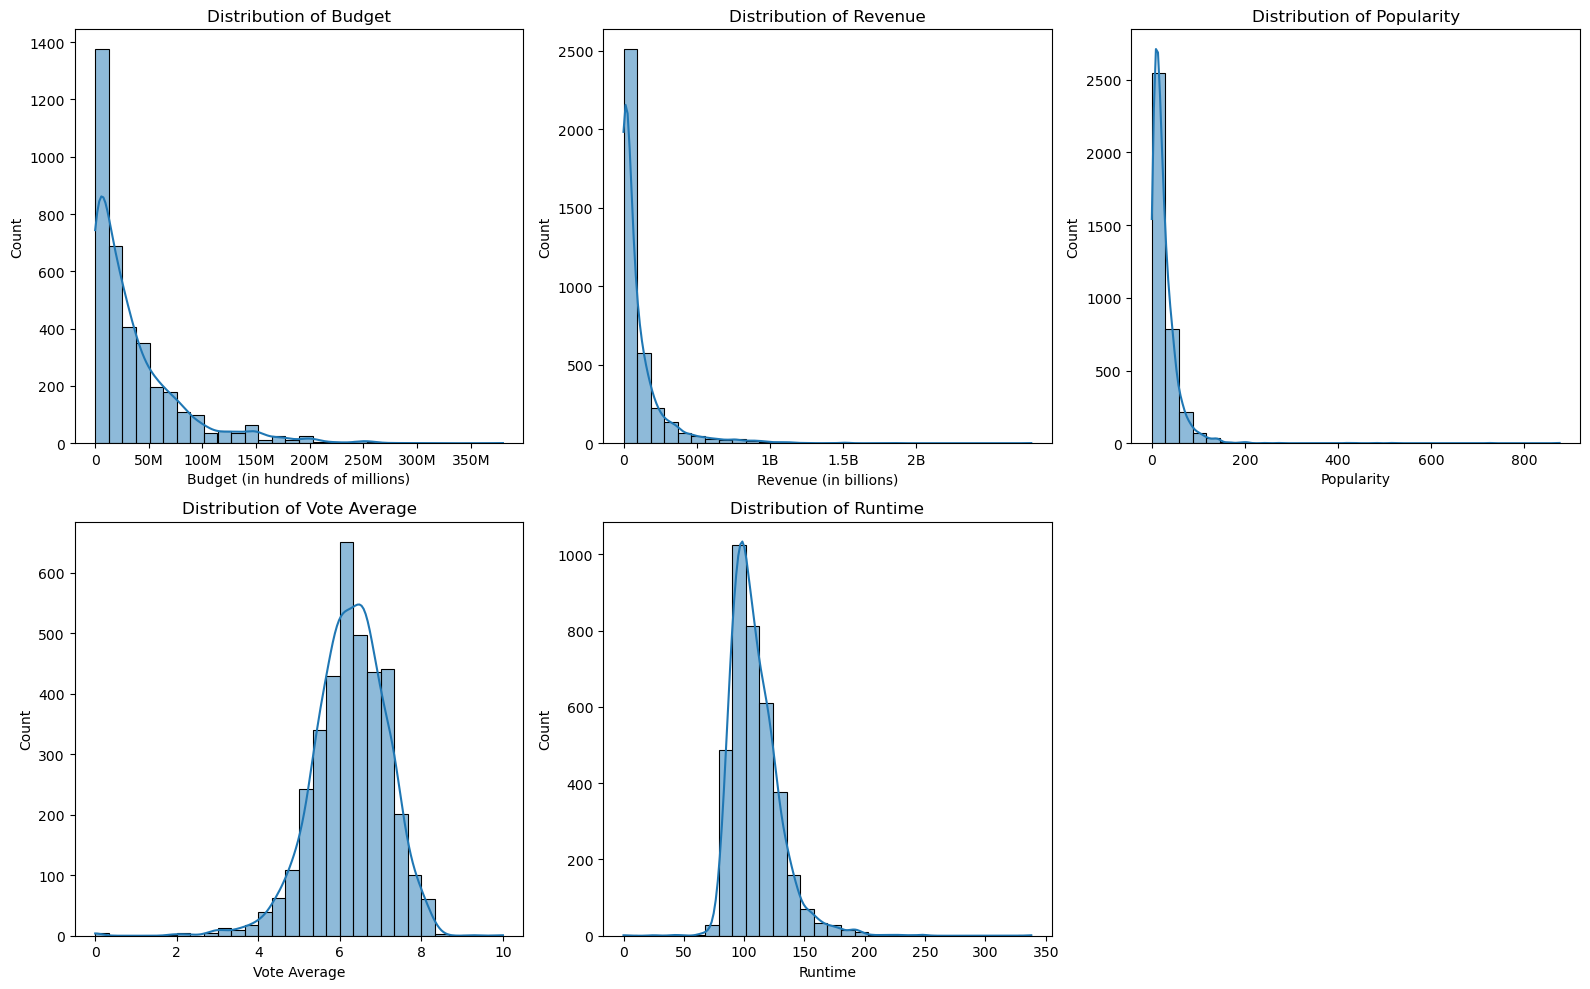

In [106]:
# Create distributions for different variables 
# Set the plot size
plt.figure(figsize=(16, 10))

# Plot the distribution of Budget with bins and formatted x-axis
plt.subplot(2, 3, 1)
sns.histplot(final_movies_df['budget'], kde=True, bins=30)
plt.title('Distribution of Budget')
plt.xlabel('Budget (in hundreds of millions)')
plt.xticks([0, 50000000, 100000000, 150000000, 200000000, 250000000, 300000000, 350000000], 
           ['0', '50M', '100M', '150M', '200M', '250M', '300M', '350M'])

# Plot the distribution of Revenue with bins and formatted x-axis
plt.subplot(2, 3, 2)
sns.histplot(final_movies_df['revenue'], kde=True, bins=30)
plt.title('Distribution of Revenue')
plt.xlabel('Revenue (in billions)')
plt.xticks([0, 500000000, 1000000000, 1500000000, 2000000000], 
           ['0', '500M', '1B', '1.5B', '2B'])

# Plot the distribution of Popularity
plt.subplot(2, 3, 3)
sns.histplot(final_movies_df['popularity'], kde=True, bins=30)
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')

# Plot the distribution of Vote Average
plt.subplot(2, 3, 4)
sns.histplot(final_movies_df['vote_average'], kde=True, bins=30)
plt.title('Distribution of Vote Average')
plt.xlabel('Vote Average')

# Plot the distribution of Runtime
plt.subplot(2, 3, 5)
sns.histplot(final_movies_df['runtime'], kde=True, bins=30)
plt.title('Distribution of Runtime')
plt.xlabel('Runtime')

# Adjust layout and display all plots
plt.tight_layout()
plt.show()


Distribution Insights:
- Budget is skewed to the left, indicating that many movies have a smaller budget with a few with significantly larger budgets.
- Revenue is skewed to the left as well, some movies did not generate any revenue.
- Popularity is skewed to the left, where most movies have a relatively low popularity.
- Vote Average does have a relatviely normal distribution with a small tail to the left but majority of the movies are rated between 5 and 7, where a few outliers.
- Runtime is also normally distributed, with most movies being around 90 to 120 minutes long. 

<Figure size 1600x600 with 0 Axes>

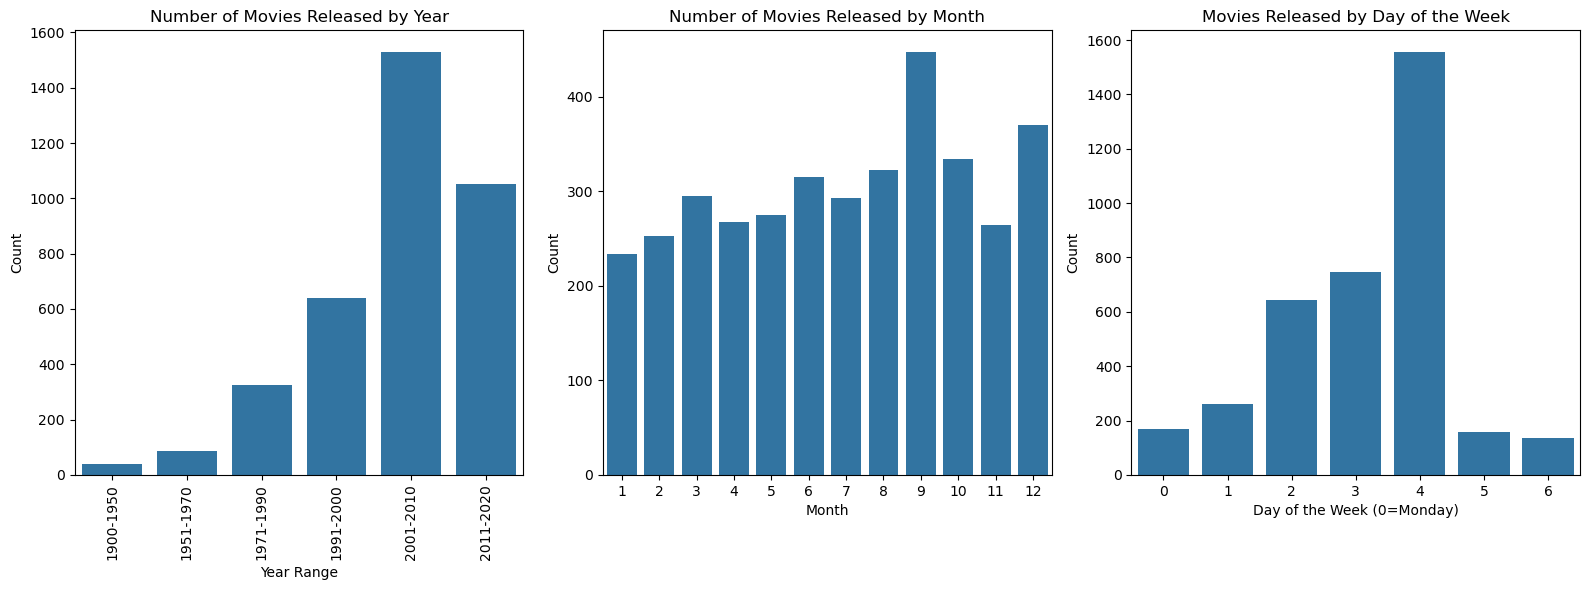

In [107]:
# Set plot size for all subplots
plt.figure(figsize=(16, 6))

# Define bins for release years 
year_bins = [1900, 1950, 1970, 1990, 2000, 2010, 2020]
year_labels = ['1900-1950', '1951-1970', '1971-1990', '1991-2000', '2001-2010', '2011-2020']
final_movies_df['release_year_bins'] = pd.cut(final_movies_df['release_year'], bins=year_bins, labels=year_labels, right=False)

# Set plot size for all subplots
plt.figure(figsize=(16, 6))

# Count of Movies Released in Each Year Bin
plt.subplot(1, 3, 1)
sns.countplot(x='release_year_bins', data=final_movies_df)
plt.xticks(rotation=90)
plt.title('Number of Movies Released by Year')
plt.xlabel('Year Range')
plt.ylabel('Count')


# Distribution of Movies Released by Month
plt.subplot(1, 3, 2)
sns.countplot(x='release_month', data=final_movies_df)
plt.title('Number of Movies Released by Month')
plt.xlabel('Month')
plt.ylabel('Count')

# Distribution of Movies Released by Day of the Week
plt.subplot(1, 3, 3)
sns.countplot(x='release_dayofweek', data=final_movies_df)
plt.title('Movies Released by Day of the Week')
plt.xlabel('Day of the Week (0=Monday)')
plt.ylabel('Count')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

Distribution Insights:
- Movies Released by Year plot highlights an increase in the number of movies releases over time, especiall from the mid-1990s onwards.
- Movies Released by Month plot highlights that the release of movies is fairly consistent across months, though months like December and May have slightly more releases, potentially due to holiday season. 
- Movies Released by Day of the Week highlights that Fridays (4) are the most popular days for movie releases.

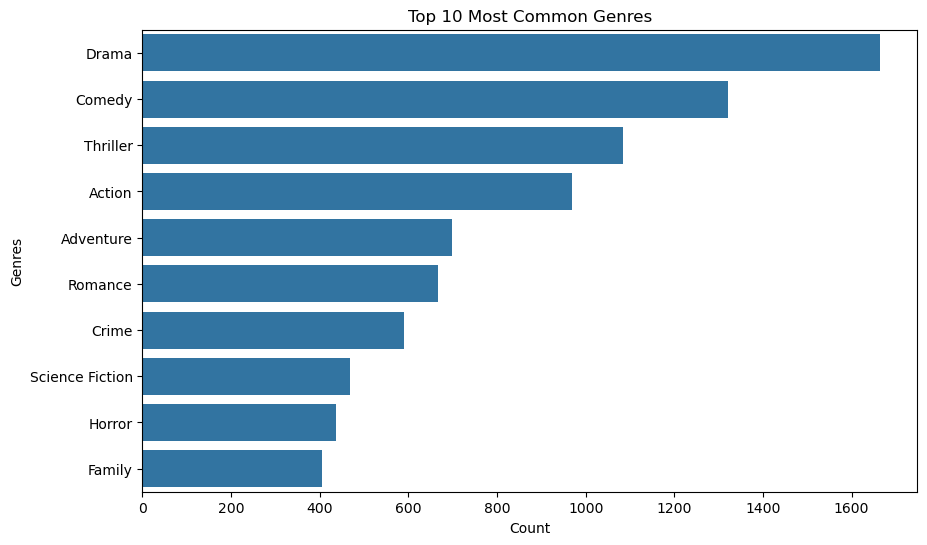

In [108]:
# Distribution of genres 
# Plot distribution of genres
plt.figure(figsize=(10, 6))

# Split genres column into multiple rows (explode) and reset index
genres_exploded = final_movies_df['genres'].str.split(', ').explode().reset_index(drop=True)

# Plot top 10 most frequent genres
sns.countplot(y=genres_exploded, order=genres_exploded.value_counts().index[:10])
plt.title('Top 10 Most Common Genres')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.show()


### Visualizing Correlation of Variables 

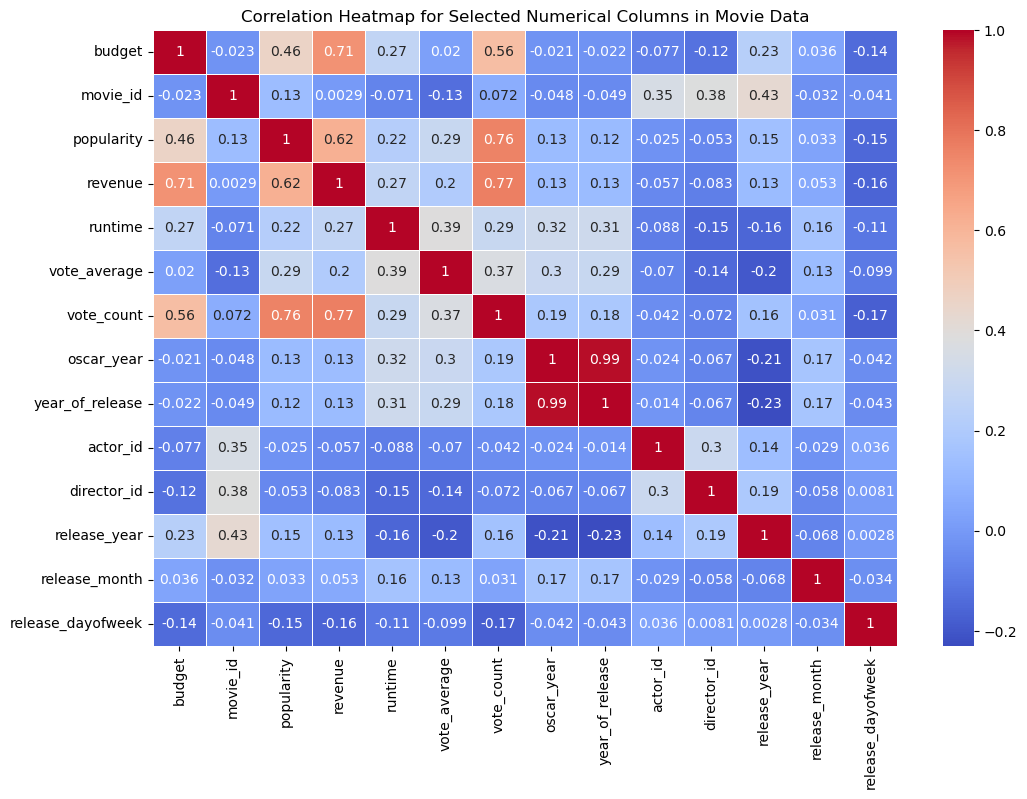

In [109]:
# Select the relevant numerical columns for the correlation matrix
numerical_columns = [
    'budget', 'movie_id', 'popularity', 'revenue', 'runtime', 
    'vote_average', 'vote_count', 'oscar_year', 'year_of_release',
    'actor_id', 'director_id', 'release_year', 'release_month', 'release_dayofweek'
]

# Calculate the correlation matrix for the selected columns
correlation_matrix = final_movies_df[numerical_columns].corr()

# Create the heatmap with the selected numerical columns
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Selected Numerical Columns in Movie Data')
plt.show()

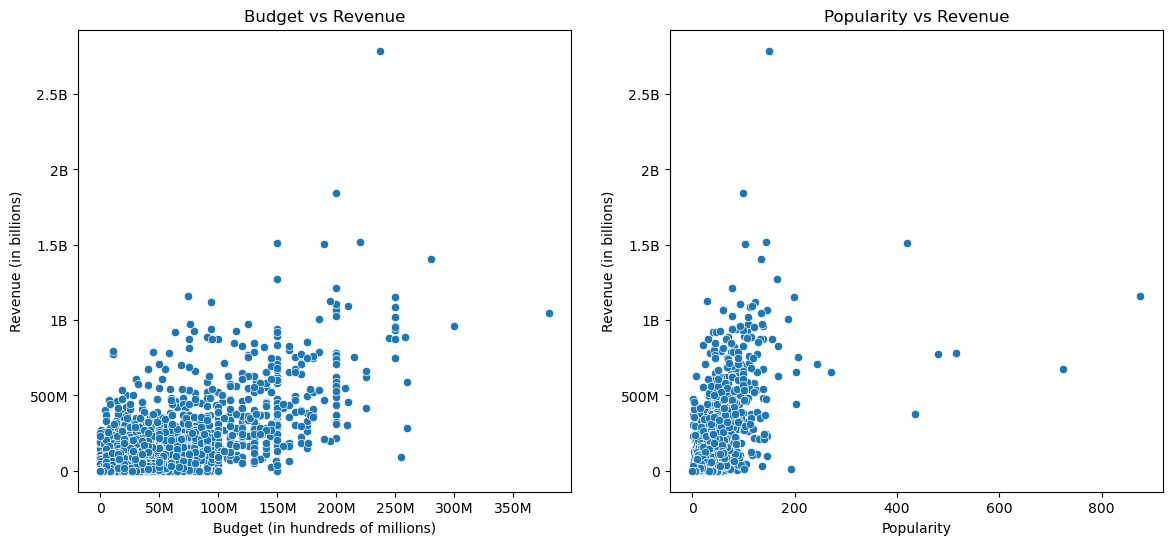

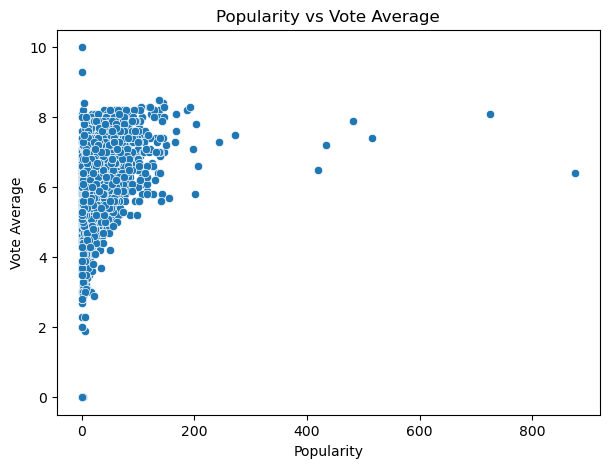

In [110]:
# Create scatter plots to explore various relationships 
# Set the plot size
plt.figure(figsize=(14, 6))

# Scatter plot for Budget vs Revenue
plt.subplot(1, 2, 1)
sns.scatterplot(x='budget', y='revenue', data=final_movies_df)
plt.title('Budget vs Revenue')
plt.xlabel('Budget (in hundreds of millions)')
plt.ylabel('Revenue (in billions)')
plt.xticks([0, 50000000, 100000000, 150000000, 200000000, 250000000, 300000000, 350000000], 
           ['0', '50M', '100M', '150M', '200M', '250M', '300M', '350M'])
plt.yticks([0, 500000000, 1000000000, 1500000000, 2000000000, 2500000000], 
           ['0', '500M', '1B', '1.5B', '2B', '2.5B'])

# Scatter plot for Popularity vs Revenue
plt.subplot(1, 2, 2)
sns.scatterplot(x='popularity', y='revenue', data=final_movies_df)
plt.title('Popularity vs Revenue')
plt.xlabel('Popularity')
plt.ylabel('Revenue (in billions)')
plt.yticks([0, 500000000, 1000000000, 1500000000, 2000000000, 2500000000], 
           ['0', '500M', '1B', '1.5B', '2B', '2.5B'])

# Scatter Plot for Popularity vs Vote Average
plt.figure(figsize=(7, 5))
sns.scatterplot(x='popularity', y='vote_average', data=final_movies_df)
plt.title('Popularity vs Vote Average')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.show()

 Correlation Insights:
- Budget vs Revenue: Strong positve correlation, indicating that high-budget movies tend to generate more revenue.
- Popularity vs Revenue: A moderate positive relationship, indicating that more popular films generally make more revenue.
- Vote Average: A weaker correlation with the other variables, indicating that ratingns may not strongly correlate with budget or popularity. 


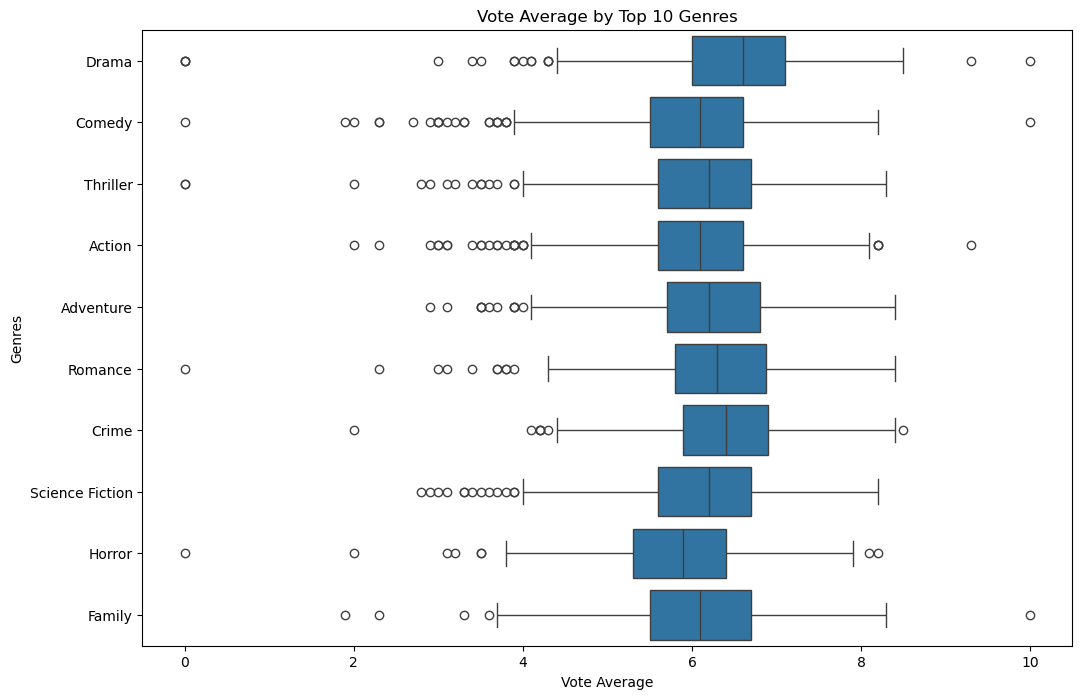

In [111]:
# Ensure genres are split by comma and exploded into individual rows
genres_exploded = final_movies_df.assign(genres=final_movies_df['genres'].str.split(', ')).explode('genres').reset_index(drop=True)

# Plot Vote Average by the top 10 most common Genres
plt.figure(figsize=(12, 8))

# Order by the most common genres and limit to top 10
top_genres = genres_exploded['genres'].value_counts().index[:10]
sns.boxplot(x='vote_average', y='genres', data=genres_exploded[genres_exploded['genres'].isin(top_genres)], order=top_genres)

plt.title('Vote Average by Top 10 Genres')
plt.xlabel('Vote Average')
plt.ylabel('Genres')
plt.show()


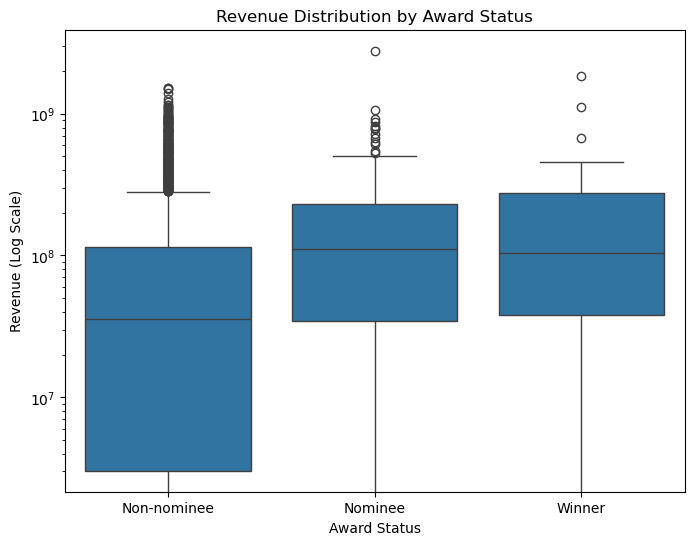

In [112]:
# Correlation between revenue and award status
plt.figure(figsize=(8, 6))

# Create a boxplot of revenue by award status
sns.boxplot(x='award', y='revenue', data=final_movies_df)
plt.yscale('log')  # Use log scale to handle extreme revenue values
plt.title('Revenue Distribution by Award Status')
plt.xlabel('Award Status')
plt.ylabel('Revenue (Log Scale)')
plt.show()


Boxplot Insights: Visualizes the median revenue for winners is significantly higher, though the log scale reveals some outliers with extremely high earnings.

C:\Users\sunny\AppData\Local\Temp\ipykernel_16968\1899447244.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='director_name', y='vote_average', data=final_movies_df[final_movies_df['director_name'].isin(top_directors)], ci=None)


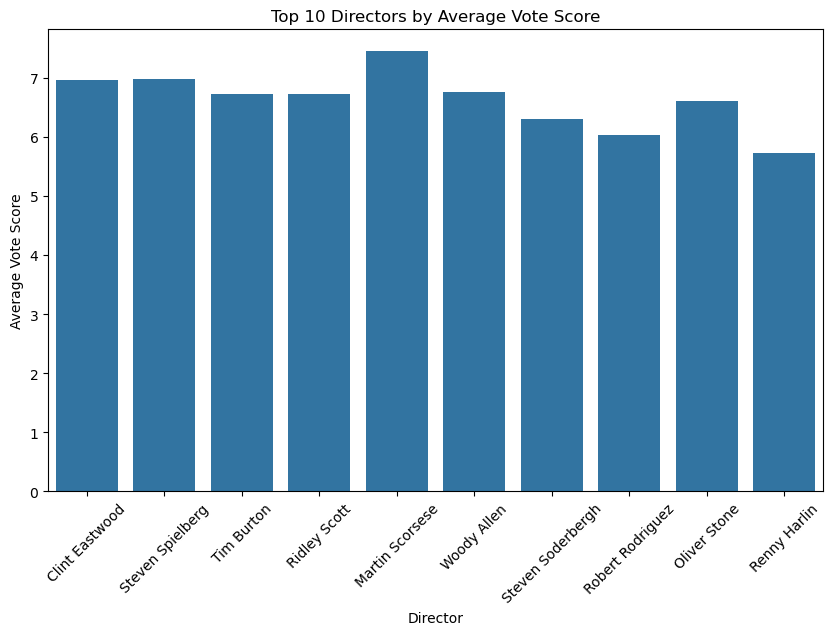

In [113]:
# Correlation between top 10 directors and average vote score 
plt.figure(figsize=(10, 6))

# Filter for top 10 most frequent directors
top_directors = final_movies_df['director_name'].value_counts().index[:10]

# Create a barplot for the average vote score by top 10 directors
sns.barplot(x='director_name', y='vote_average', data=final_movies_df[final_movies_df['director_name'].isin(top_directors)], ci=None)
plt.title('Top 10 Directors by Average Vote Score')
plt.xticks(rotation=45)
plt.xlabel('Director')
plt.ylabel('Average Vote Score')
plt.show()


Bar Chart Insights: Directors like Christopher Nolan and Quentin Tarantino have movies that consistently receive higher average votes. 

C:\Users\sunny\AppData\Local\Temp\ipykernel_16968\2003506020.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='actor', y='revenue', data=final_movies_df[final_movies_df['actor'].isin(top_actors)], ci=None)


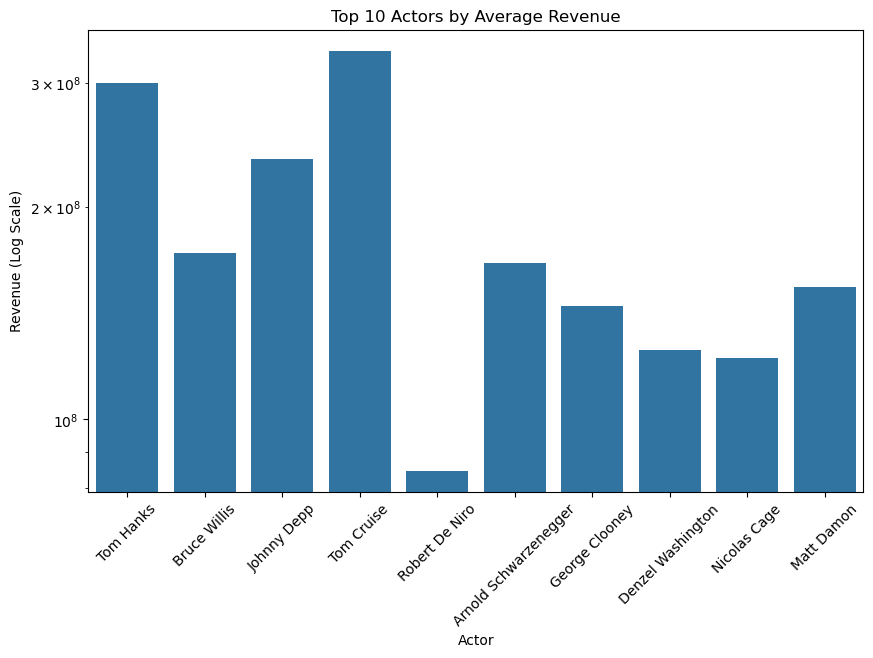

In [114]:
# Correlation between top 10 actors and revenue
plt.figure(figsize=(10, 6))

# Filter for top 10 most frequent actors
top_actors = final_movies_df['actor'].value_counts().index[:10]

# Create a barplot for the average revenue by top 10 actors
sns.barplot(x='actor', y='revenue', data=final_movies_df[final_movies_df['actor'].isin(top_actors)], ci=None)
plt.yscale('log')  # Use log scale to handle extreme revenue values
plt.title('Top 10 Actors by Average Revenue')
plt.xticks(rotation=45)
plt.xlabel('Actor')
plt.ylabel('Revenue (Log Scale)')
plt.show()

Bar Chart Insights: Tom Hanks and Brad Pitt are associated with movies that generate higher revenues. 

# Machine Learning - Linear Regression Model(s)

### Baseline Linear Regression Model

Baseline Linear Regression: We started with a basic model that tried to predict movie popularity based on a few features.

- Dropped unnecessary coulmns that do not provide predictive power. 

In [115]:
# Dropping unnecessary columns
regression_df = final_movies_df.drop(columns=['movie_id', 'status', 'language', 'release_date','tagline', 'keywords', 'production', 'release_year_bins', 'movie_title'])
regression_df.head(5)


,budget,popularity,revenue,runtime,vote_average,vote_count,full_original_name,country_short,country_name,release_date_season,...,year_of_release,award,actor_id,actor,director_id,director_name,genres,release_year,release_month,release_dayofweek
0,4000000.0,22.9,4300000.0,98,6.5,500,English,US,United States of America,Winter,...,0,Non-nominee,3129,Tim Roth,3110,Allison Anders,"Crime, Comedy",1995,12,5
1,11000000.0,126.4,775398007.0,121,8.1,6600,English,US,United States of America,Spring,...,1977,Nominee,2,Mark Hamill,1,George Lucas,"Adventure, Action, Science Fiction",1977,5,2
2,94000000.0,85.7,940335536.0,100,7.6,6100,English,US,United States of America,Spring,...,0,Non-nominee,13,Albert Brooks,7,Andrew Stanton,"Animation, Family",2003,5,4
3,55000000.0,138.1,677945399.0,142,8.2,7900,English,US,United States of America,Summer,...,1994,Winner,31,Tom Hanks,24,Robert Zemeckis,"Comedy, Drama, Romance",1994,7,2
4,15000000.0,80.9,356296601.0,122,7.9,3300,English,US,United States of America,Fall,...,1999,Winner,1979,Kevin Spacey,39,Sam Mendes,Drama,1999,9,2


In [116]:
null_df = regression_df.isnull().sum()
print(null_df)

budget                 0
popularity             0
revenue                0
runtime                0
vote_average           0
vote_count             0
full_original_name     0
country_short          0
country_name           0
release_date_season    0
oscar_year             0
year_of_release        0
award                  0
actor_id               0
actor                  0
director_id            0
director_name          0
genres                 0
release_year           0
release_month          0
release_dayofweek      0
dtype: int64


By creating a new feature called budget_runtime_interaction, we might be able capture any relationship between budget and runtime that may influence popularity. 

In [117]:
# Feature Engineering: Adding interaction terms (budget * runtime, etc.)
regression_df['budget_runtime_interaction'] = regression_df['budget'] * regression_df['runtime']

In [118]:
# Apply log transformation to revenue, budget, and popularity to normalize their distribution
regression_df['revenue_log'] = np.log1p(regression_df['revenue'])
regression_df['budget_log'] = np.log1p(regression_df['budget']) 
regression_df['popularity_log'] = np.log1p(regression_df['popularity'])

In [119]:
# from scipy improt stats 
# stat, p = stat,shapiro(regression_df)
# print('Shapiro-Wilk Test')
# print(f'Statistics={stat}, p-value={p}')

# if p > 0.05:
#     print('Data looks normally distributed')
# else:
#     print('Data does not look normally distributed')

In [120]:
# Drop the original columns revenue, budget, and popularity
regression_df = regression_df.drop(['revenue', 'budget', 'popularity'], axis=1)

In [121]:
# Import necessary libraries
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to 'release_month' and 'release_dayofweek' columns
regression_df['release_month_encoded'] = label_encoder.fit_transform(regression_df['release_month'])
regression_df['release_dayofweek_encoded'] = label_encoder.fit_transform(regression_df['release_dayofweek'])

# Step 4: Display the updated dataframe to verify the transformations
regression_df[['release_month', 'release_month_encoded', 'release_dayofweek', 'release_dayofweek_encoded']].head(5)

,release_month,release_month_encoded,release_dayofweek,release_dayofweek_encoded
0,12,11,5,5
1,5,4,2,2
2,5,4,4,4
3,7,6,2,2
4,9,8,2,2


In [122]:
# Drop the columns release_month and 'release_dayofweek
regression_df = regression_df.drop(['release_month', 'release_dayofweek'], axis=1)

In [123]:
regression_df['vote_count'].describe()



count     3672.000000
mean       865.413943
std       1350.305672
min          0.000000
25%        100.000000
50%        400.000000
75%       1000.000000
max      13800.000000
Name: vote_count, dtype: float64

In [124]:
# Apply log transformation to vote_count
regression_df['vote_count_log'] = np.log1p(regression_df['vote_count'])  

# Display the first few rows to verify the transformation
regression_df[['vote_count', 'vote_count_log']].head()

,vote_count,vote_count_log
0,500,6.216606
1,6600,8.794976
2,6100,8.716208
3,7900,8.974745
4,3300,8.101981


In [125]:
# Drop the columns release_month and 'release_dayofweek
regression_df = regression_df.drop(['vote_count'], axis=1)

In [126]:
# Selecting relevant features based on the correlation and distribution analysis
selected_features = ['budget_log', 'runtime', 'vote_average', 
                     'vote_count_log', 'release_month_encoded', 'release_dayofweek_encoded', 
                     'revenue_log', 'budget_runtime_interaction']

In [127]:
# Splitting data into features (X) and target (y)
X = regression_df[selected_features]
y = regression_df['popularity_log']

scaling revelant features and not scaling categorical features that are encoded 

In [128]:
# Standardizing relevant features 
scaler = StandardScaler()
columns_to_scale = ['budget_log','revenue_log', 'runtime', 'vote_average', 'vote_count_log', 'budget_runtime_interaction']
X_scaled = X.copy()

X_scaled[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

In [129]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [130]:
# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [131]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [132]:
# Evaluate the model using Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display the evaluation results
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

Root Mean Squared Error (RMSE): 0.4402736858602095
R-squared (R²): 0.7982102504146665


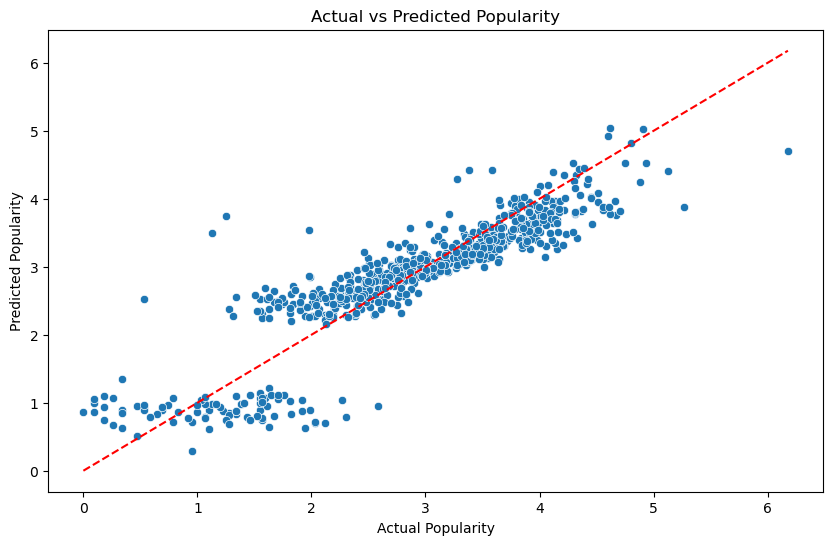

In [133]:
# Create a DataFrame with the actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Create a scatter plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df)

# Add a line for perfect predictions
plt.plot([results_df.min().min(), results_df.max().max()], 
         [results_df.min().min(), results_df.max().max()], color='red', linestyle='--')

# Add labels and title
plt.title('Actual vs Predicted Popularity')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.show()

In [134]:
# Convert the scaled data back to a DataFrame for easier inspection
selected_features = ['budget', 'runtime', 'vote_average', 'vote_count_log', 
                     'release_month_encoded', 'release_dayofweek_encoded', 'budget_runtime_interaction']

X_scaled_df = pd.DataFrame(X_scaled, columns=selected_features)

# Check the mean and standard deviation of each column
means = X_scaled_df.mean(axis=0)
stds = X_scaled_df.std(axis=0)

# Output the results
print("Means of the scaled features:\n", means)
print("\nStandard deviations of the scaled features:\n", stds)

Means of the scaled features:
 budget                                 NaN
runtime                       9.288140e-17
vote_average                  3.715256e-16
vote_count_log                1.702826e-16
release_month_encoded         5.893519e+00
release_dayofweek_encoded     3.167484e+00
budget_runtime_interaction   -1.548023e-17
dtype: float64

Standard deviations of the scaled features:
 budget                             NaN
runtime                       1.000136
vote_average                  1.000136
vote_count_log                1.000136
release_month_encoded         3.376387
release_dayofweek_encoded     1.333923
budget_runtime_interaction    1.000136
dtype: float64


Explain what happened 

### Random Forest

Making a copy of the regression_df that has been perprocessed and prepared for the machine learning model. 

In [135]:
# Copy the original machine learning dataframe
forest_df = regression_df.copy()
forest_df.head(5)

,runtime,vote_average,full_original_name,country_short,country_name,release_date_season,oscar_year,year_of_release,award,actor_id,...,director_name,genres,release_year,budget_runtime_interaction,revenue_log,budget_log,popularity_log,release_month_encoded,release_dayofweek_encoded,vote_count_log
0,98,6.5,English,US,United States of America,Winter,0,0,Non-nominee,3129,...,Allison Anders,"Crime, Comedy",1995,3.920000e+08,15.274126,15.201805,3.173878,11,5,6.216606
1,121,8.1,English,US,United States of America,Spring,1977,1977,Nominee,2,...,George Lucas,"Adventure, Action, Science Fiction",1977,1.331000e+09,20.468887,16.213406,4.847332,4,2,8.794976
2,100,7.6,English,US,United States of America,Spring,0,0,Non-nominee,13,...,Andrew Stanton,"Animation, Family",2003,9.400000e+09,20.661747,18.358805,4.462454,4,4,8.716208
3,142,8.2,English,US,United States of America,Summer,1994,1994,Winner,31,...,Robert Zemeckis,"Comedy, Drama, Romance",1994,7.810000e+09,20.334577,17.822844,4.935193,6,2,8.974745
4,122,7.9,English,US,United States of America,Fall,1999,1999,Winner,1979,...,Sam Mendes,Drama,1999,1.830000e+09,19.691274,16.523561,4.405499,8,2,8.101981


In [136]:
# Selecting relevant columns
features = ['budget_log', 'revenue_log', 'runtime', 'vote_average', 'release_year', 'budget_runtime_interaction', 'release_month_encoded', 'release_dayofweek_encoded']
X = forest_df[features]

# Target variable
y = forest_df['popularity_log']

In [137]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [138]:
from sklearn.ensemble import RandomForestRegressor
# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [139]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

In [140]:
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-Squared: {r2}')

Mean Squared Error: 0.323980507603483
R-Squared: 0.6627340294355263


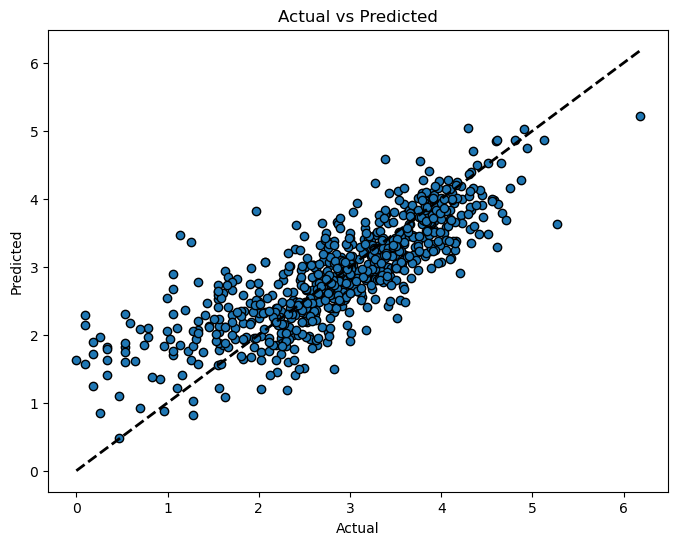

In [141]:
# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [142]:
# Feature Importance
importances = rf_model.feature_importances_
for feature, importance in zip(features, importances):
    print(f'{feature}: {importance}')

budget_log: 0.03813060294241399
revenue_log: 0.5739059326804703
runtime: 0.06334123440832942
vote_average: 0.11852105397884871
release_year: 0.09856989209535749
budget_runtime_interaction: 0.04484595158074491
release_month_encoded: 0.03636687899464688
release_dayofweek_encoded: 0.02631845331918831


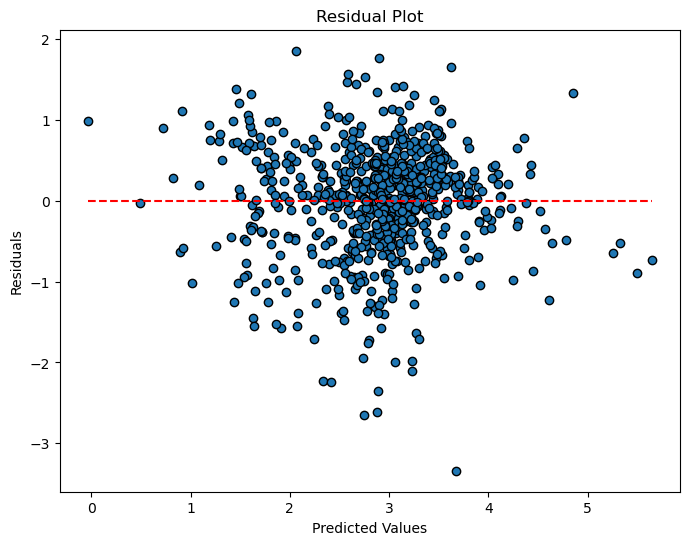

In [150]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, edgecolors=(0, 0, 0))
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Random Forest Optimization 

In [ ]:
# Adding interaction terms using budget and rvenue 

